```{index} single: Pyomo; block
```
```{index} single: Pyomo; kernel library
```
```{index} single: application; support vector machines
```
```{index} single: application; binary classification
```
```{index} single: application; counterfeit banknotes
```
# Support Vector Machines for Binary Classification

Support Vector Machines (SVM) are supervised machine learning models. This notebook shows how to implement an SVM  for binary classification using linear and conic programming. The first implementation produces linear support vector machines that separates the "feature space" with a hyperplane. This is demonstrated for both primal and dual formulations. The dual formulation extends naturally to binary classification in high order feature spaces.

Like other machine learning techniques based on regression, an SVM classifier can be implemented as the solution to an optimization problem. The optimization problem runs once using training samples with known outcomes to produce parameters for a classifier. The resulting classifier can then be use to classify data with unknown outcomes.


In [12]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_mosek()

pyomo was previously installed
mosek was previously installed


## Binary Classification

Binary classifiers are functions designed to answer questions such as "does this medical test indicate disease?", "will this specific customer enjoy that specific movie?", "does this photo include a car?", or "is this banknote genuine or counterfeit?" These questions are answered based on the values of "features", which may include physical measurements or other types of data collected from a representative sample with known outcomes.

For example, consider a device installed in a vending machine to detect banknotes. The classifier's goal is to accurately identify and accept genuine banknotes while rejecting counterfeit ones. The classifier's performance can be assessed using definitions in following table, where "positive" refers to an instance of a genuine banknote.

| | Predicted Positive  | Predicted Negative | |
| :-- | :--: | :--: | :-- |
| Actual Positive | True Positive (TP) | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN) |

A vending machine user would be frustrated if a genuine banknote is incorrectly rejected as a false negative. **Recall** is defined as the number of true positives (TP) divided by the total number of actual positives (TP + FN). A high recall implies a low false negative rate, making it the preferred outcome for users.

The vending machine owner, on the other hand, wants the machine to avoid accepting counterfeit banknotes and would therefore prefer a low number of false positives (FP). **Precision** is the number of true positives (TP) divided by the total number of predicted positives (TP + FP). A high precision implies a low false positive rate, making it the preferred outcome for the owner.

* **Recall**: The number of true positives divided by the total number of actual positives. High recall indicates a low false negative rate.

* **Precision**: The number of true positives identified by the model divided by the total number of predicted positives, which includes both true and false positives. High precision indicates a low false positive rate.

To achieve high recall, a classifier can follow the "innocent until proven guilty" standard, rejecting banknotes only when certain they are counterfeit. To achieve high precision, a classifier can adopt the "guilty unless proven innocent" standard, accepting banknotes only when certain they are genuine. The challenge in developing binary classifiers is to balance these conflicting objectives and optimize performance from both perspectives simultaneously.

## The Data Set 

The following data set contains data from a collection of known genuine and known counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images named "variance", "skewness", "curtosis", and "entropy", and a binary variable named "class" which is 0 if genuine and 1 if counterfeit.

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

### Read data

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# read data set
df = pd.read_csv("data_banknote_authentication.txt", header=None)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"

# show a few rows
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [14]:
# get a statistical description of the data set
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


### Select features and training sets

Following customary practices, we divide the data set into a **training set** used to trail the classifier, and a **testing set** that will be used to evaluate the performance of the classifier. In addition, we select two dimensional subset of the features to enable plotting of the results for exposition. Since our definition of a positive outcome corresponds to detecting a genuine banknote, we rescale the "class" feature to have values of 1 for genuine banknotes and -1 for counterfeit banknotes. 

Text(0.5, 1.0, 'Banknote Training Set')

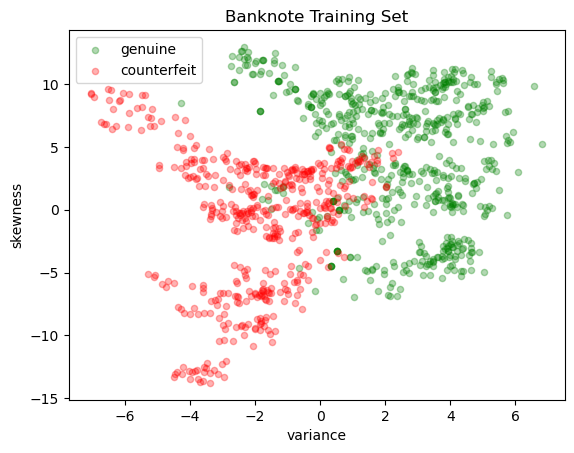

In [15]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)

# select training features
features = ["variance", "skewness"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

# plot the training set
fig, ax = plt.subplots()

kwargs = {"x": "variance", "y": "skewness", "kind": "scatter", "ax": ax, "alpha": 0.3}

# catch and ignore warnings from matplotlib scatter plot
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_train[y_train > 0].plot(**kwargs, c="g", label="genuine")
    X_train[y_train < 0].plot(**kwargs, c="r", label="counterfeit")
ax.set_title("Banknote Training Set")

## Support vector machines (SVM)

### A linear SVM classifier

A linear support vector machine (SVM) is a binary classification method that employs a linear equation to determine the class assignment. The basic  formula is expressed as:

$$y^{pred} = \text{sgn}\ ( w^\top x + b)$$

where $x$ is a point $x\in\mathbb{R}^p$ in "feature" space. Here $w\in \mathbb{R}^p$ represents a set of coefficients, $w^\top x$ is the dot product, and $b$ is a scalar coefficient.  The linear function divides the feature space using the hyperplane defined by $w$ and $b$. Points on one side of the hyperplane are assigned a positive outcome (+1), while points on the other side are assigned a negative outcome (-1).

The following code cell contains a Python implementation of a linear SVM. An instance of `LinearSVM` is defined with a coefficient vector $w$ and a scalar $b$. In this implementation, all data and parameters are provided as Pandas Series or DataFrame objects, and use the Pandas `.dot()` function is used to compute the necessary dot product.

In [16]:
import pandas as pd
import numpy as np

class LinearSvm():
    
    def __init__(self, w, b):
        self.w = pd.Series(w)
        self.b = b
        
    def predict(self, X):
        return np.sign(X.dot(self.w) + self.b)

A visual inspection of training set for the banknote, shown above, shows the two dimensional feature set can be roughly split along the vertical axis where "variance" is zero. Most of the positive outcomes are on the right of the axis, most of the negative outcomes on the left. Since $w$ is a vector normal to this surface, we choose 

$$
\begin{align}
    w & = \begin{bmatrix} w_{variance} \\ w_{skewness} \end{bmatrix} = \begin{bmatrix} 1 \\ 0 \end{bmatrix},
    \qquad b = 0
\end{align}
$$

The code cell below evaluates the accuracy of the linear SVM by calculating the **accuracy score**, which is the fraction of samples that were predicted accurately.

In [17]:
# Visual estimaate of w and b for a linear classifier
w = pd.Series({'variance': 1, 'skewness': 0})
b = 0

# create an instance of LinearSVM
svm_v0 = LinearSvm(w, b)

# predictions for the training set
y_pred = svm_v0.predict(X_test)

# fraction of correct predictions
accuracy = sum(y_pred == y_test) / len(y_test)
print(f"Accuracy = {100 * accuracy_score: 0.1f}%")

Accuracy =  87.3%


### Performance metrics

The accuracy score alone is not always a reliable metric for evaluating the performance of binary classifiers. For instance, when one outcome is significantly more frequent than the other, a classifier that always predicts the more common outcome without regard to the feature vector can achieve. Moreover, in many applications, the consequences of a false positive can differ from those of a false negative. For these reasons, we seek a more comprehensive set of metrics to compare binary classifiers. A [detailed discussion on this topic](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7) recommends the [Matthews correlation coefficient (MCC)](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a) as a reliable performance measure for binary classifiers.

The code below demonstrates an example of a function that evaluates the performance of a binary classifier and returns the Matthews correlation coefficient as its output.

In [18]:
def validate(y_true, y_pred, verbose=True):
    """
    This function calculates and displays the recall, precision, and Matthews correlation coefficient (MCC)
    for a binary classifier based on its true labels (y_true) and predicted labels (y_pred).
    
    Args:
    y_true (array-like): A list or array containing the true labels of the samples.
    y_pred (array-like): A list or array containing the predicted labels of the samples.
    verbose (bool, optional): If True, the function prints and displays the calculated metrics and 
                              confusion matrix. Defaults to True.
    
    Returns:
    float: The calculated Matthews correlation coefficient (MCC).
    """

    # Calculate the elements of the confusion matrix
    true_positives = sum((y_true > 0) & (y_pred > 0))
    false_negatives = sum((y_true > 0) & (y_pred < 0))
    false_positives = sum((y_true < 0) & (y_pred > 0))
    true_negatives = sum((y_true < 0) & (y_pred < 0))
    total = true_positives + true_negatives + false_positives + false_negatives

    # Calculate the Matthews correlation coefficient (MCC)
    mcc_numerator = (true_positives * true_negatives) - (false_positives * false_negatives)
    mcc_denominator = np.sqrt((true_positives + false_positives) \
                              * (true_positives + false_negatives) \
                              * (true_negatives + false_positives) \
                              * (true_negatives + false_negatives))
    mcc = mcc_numerator / mcc_denominator

    if verbose:
        print(f"Matthews correlation coefficient (MCC) = {mcc:0.3f}")
        
        # report recall and precision, and accuracy
        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        accuracy = (true_positives + true_negatives) / total
        
        print(f"Precision = {100 * precision: 0.1f}%") 
        print(f"Recall = {100 * recall: 0.1f}%")    
        print(f"Accuracy = {100 * accuracy: 0.1f}%")

        # Display the binary confusion matrix
        confusion_matrix = pd.DataFrame(
            [[true_positives, false_negatives], [false_positives, true_negatives]], 
            index = ["Actual Positive", "Actual Negative"], columns=["Predicted Positive", "Predicted Negative"])
        display(confusion_matrix)

    return mcc

y_pred = svm_v0.predict(X_test)
validate(y_test, y_pred);

Matthews correlation coefficient (MCC) = 0.665
Precision =  83.6%
Recall =  84.7%
Accuracy =  83.3%


,Predicted Positive,Predicted Negative
Actual Positive,122,22
Actual Negative,24,107


## A linear optimization model to train a linear SVM

A training or validation set consists of $n$ observations $(x_i, y_i)$ where $y_i = \pm 1$ and $x_i\in\mathbb{R}^p$ for $i=1, \dots, n$. The training task is to find coefficients $w\in\mathbb{R}^p$ and $b\in\mathbb{R}$ to achieve high precision and high recall for the validation set. All points $(x_i, y_i)$ for $i\in 1, \dots, n$ in a training or validation set are successfully classified if the
 
$$
\begin{align}
    y_i (w^\top x_i + b) & > 0 & \forall i = 1, 2, \dots, n.
\end{align}
$$

As written, this condition imposes no scale for $w$ or $b$ (that is, if the condition is satisfied for any pair $(w, b)$ then it also satisfied for $(\gamma w, \gamma b)$ where $\gamma > 0$). It is convenient, therefore, to impose a modified condition for correctly classified points where

$$
\begin{align*}
y_i (w^\top x_i + b) & \geq 1 & \forall i = 1, 2, \dots, n
\end{align*}
$$

which defines a **hard-margin** classifier. The size of the margin is determined by the scale of $w$ and $b$. 

In practice, it is not always possible to find $w$ and $b$ that separate all the data perfectly. Therefore, we need to minimize a measure of "things going wrong". For for this purpose, when fitting an SVM to data it is common to use a **soft-margin** classifier. Given parameters $w$ and $b$, the **hinge-loss** function is defined as

$$
\ell(x, y) = \left(1 - y(w^\top x + b)\right)^+,
$$

with the notation $z^+ = \max(0, z)$. By design, for a given $(w, b)$, the hinge-loss function will be zero for any training point correctly classified by the corresponding hard-margin classifier. The hinge-loss function will be less than one for any point correctly classified by $y_i (w^\top x_i + b) > 0$. Otherwise the hinge-loss function is greater than one for any misclassified point, and grows in proportion to how far away the feature vector is from the separation plane. 

These properties make the hinge-loss function useful for training a linear support vector machine. The training problem is formulated as minimizing the hinge-loss function over all the data samples:

$$
\begin{align*}
    \min_{w, b} \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ .
\end{align*}
$$

Practice has shown that minimizing this term alone produces classifiers with large entries for $w$ which performs poorly on new data samples. For that reason, **regularization** adds a term to penalize the magnitude of $w$. In most formulations a norm $\|w\|$ is used for regularization, commonly a sum of squares such as $\|w\|_2^2$. Another choice is $\|w\|_1$ which, similar to Lasso regression, may result in sparse weighting vector $w$ indicating which elements of the feature vector can be neglected for classification purposes. These considerations result in the objective function

$$
    \min_{w, b}\left[ \lambda \|w\|_1 + \frac{1}{n}\sum_{i=1}^n \left(1 - y_i(w^\top x_i + b)\right)^+ \right]
$$

By introducing $n$ auxiliary non-negative variables $z$'s, the the needed weights are a solution to following LP:

$$
\begin{align*}
\min\quad  & \lambda \|w\|_1 + \frac{1}{n} \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i(w^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i\geq 0 & \forall i = 1, \dots, n \\
& w\in\mathbb{R}^p \\
& b\in\mathbb{R} \\
\end{align*}
$$

This is the primal optimization problem in decision variables $w\in\mathbb{R}^p$, $b\in\mathbb{R}$, and $z\in\mathbb{R}^n$, a total of $n + p + 1$ unknowns with $2n$ constraints. This can be recast as a linear program with the usual technique of setting $w = w^+ - w^-$ where $w^+$ and $w^-$ are non-negative. Then

$$
\begin{align*}
\min\quad  &\lambda \sum_{j=1}^p (w^+_j + w^-_j) + \frac{1}{n}  \sum_{i=1}^n z_i \\
\text{s.t.} \quad &  z_i \geq 1 - y_i((w^+ - w^-)^\top x_i + b) & \forall i = 1, \dots, n \\
& z_i \geq 0 & \forall i = 1, \dots, n \\
& w^+_j, w^-_j \geq 0 & \forall j = 1, \dots, p \\
& b\in\mathbb{R} \\
\end{align*}
$$

### Pyomo implementation

This optimization model for a linear SVM is implemented as a subclass of Pyomo `ConcreteClass`. An instance of the optimization model is created with a training set

The following Pyomo implementation of an this optimization model for a linear support vector machine is broken into two components. The first component is the SVM itself, which will be Python object parameterized by the coefficients $w$ and $b$ described above, and with methods to initialize itself, validate itself with test data is available, and produce predictions. This can be small Python class with a small memory footprint for instances of the class.

The second component is a linear SVM *Factory* that produces instances of SVM objects from training data and other specifications. This is where the Pyomo model will be embedded. 

In [19]:
import pyomo.environ as pyo

def linearSvmFactory(X, y, lambd=1):
        
    m = pyo.ConcreteModel()

    # use dataframe columns and index to index vars and constraints
    m.P = pyo.Set(initialize=X.columns)
    m.N = pyo.Set(initialize=X.index)

    # decision variables
    m.wp = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.wn = pyo.Var(m.P, domain=pyo.NonNegativeReals)
    m.b = pyo.Var()
    m.z = pyo.Var(m.N, domain=pyo.NonNegativeReals)

    @m.Expression(m.P)
    def w(m, p):
        return m.wp[p] - m.wn[p]

    @m.Objective(sense=pyo.minimize)
    def lasso(m):
        return sum(m.z[i] for i in m.N)/len(m.N) + lambd * sum(m.wp[p] + m.wn[p] for p in m.P)

    @m.Constraint(m.N)
    def hingeloss(m, i):
        return m.z[i] >= 1 - y[i] * (sum(m.w[p] * X.loc[i, p] for p in m.P) + m.b)

    pyo.SolverFactory('cbc').solve(m)

    w = pd.Series([m.w[p]() for p in m.P], index=m.P)
    b = m.b()

    return LinearSvm(w, b)

svm_v1 = linearSvmFactory(X_train, y_train)
print(svm_v1.w)
print(svm_v1.b)

variance    0.242992
skewness    0.053856
dtype: float64
0.016779743


In [20]:
validate(y_test, svm_v1.predict(X_test))

Matthews correlation coefficient (MCC) = 0.716
Precision =  81.3%
Recall =  93.8%
Accuracy =  85.5%


,Predicted Positive,Predicted Negative
Actual Positive,135,9
Actual Negative,31,100


0.7156161256382129

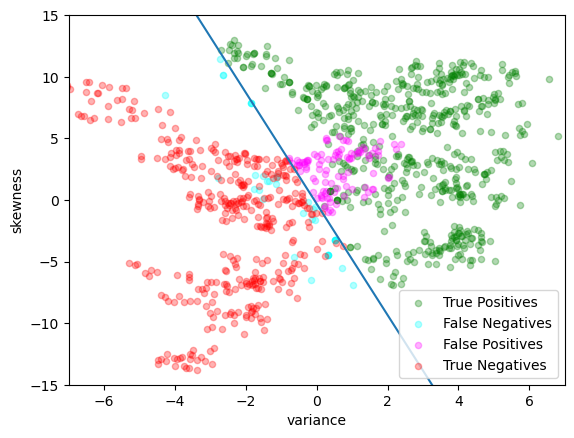

In [24]:
fig, ax = plt.subplots()
xlim = (-7, 7)
ylim = (-15, 15)

x = np.linspace(-7, 7)
y = (-svm_v1.w["variance"]*x - svm_v1.b)/svm_v1.w["skewness"]

y_pred = svm_v1.predict(X_train)

kwargs = {"x": "variance", "y": "skewness", "kind": "scatter", "ax": ax, "xlim": xlim, "ylim": ylim}

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_train[(y_pred > 0) * (y_train > 0)].plot(**kwargs, c="g", alpha=0.3, label="True Positives")
    X_train[(y_pred < 0) * (y_train > 0)].plot(**kwargs, c="cyan", alpha=0.3, label="False Negatives")
    X_train[(y_pred > 0) * (y_train < 0)].plot(**kwargs, c="magenta", alpha=0.3, label="False Positives")
    X_train[(y_pred < 0) * (y_train < 0)].plot(**kwargs, c="r", alpha=0.3, label="True Negatives")
    ax.plot(x, y)


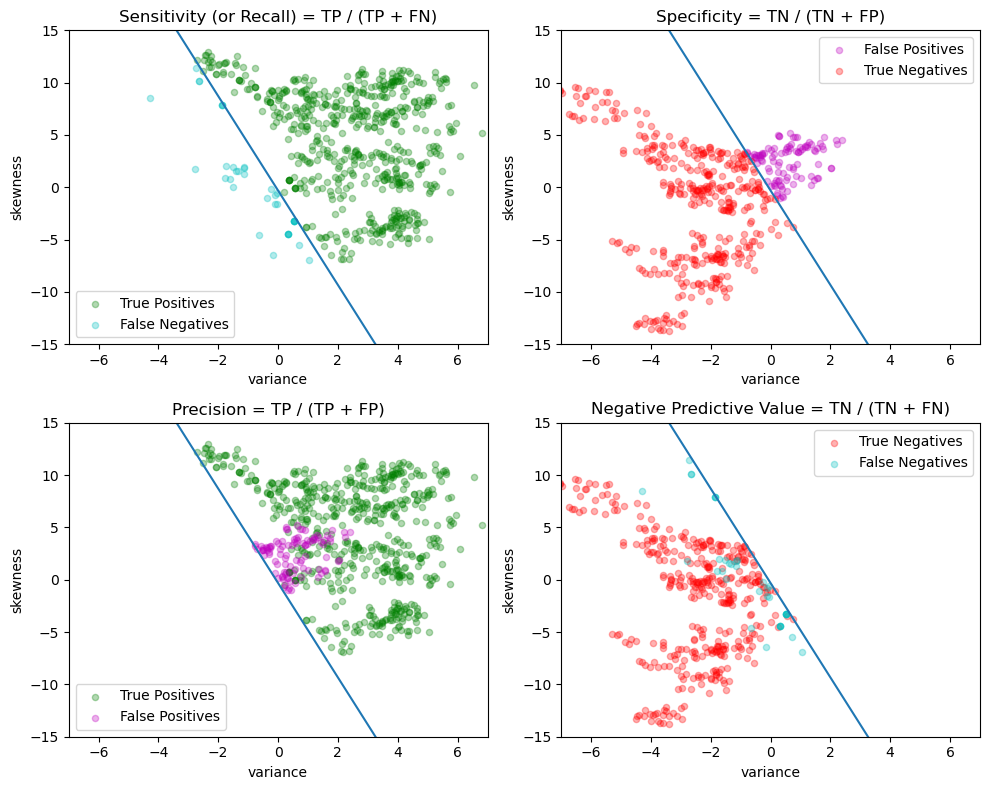

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
xlim = (-7, 7)
ylim = (-15, 15)

kwargs = {"x": "variance", "y": "skewness", "kind": "scatter", "xlim": xlim, "ylim": ylim}

# catch and ignore a warning that may be a bug with matplotlib scatter plot
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_train[(y_pred > 0) * (y_train > 0)].plot(**kwargs, ax=ax[0, 0], c="g", alpha=0.3, label="True Positives")
    X_train[(y_pred < 0) * (y_train > 0)].plot(**kwargs, ax=ax[0, 0], c="c", alpha=0.3, label="False Negatives")
    ax[0, 0].plot(x, y)
    ax[0, 0].set_title("Sensitivity (or Recall) = TP / (TP + FN)")
    
    X_train[(y_pred > 0) * (y_train < 0)].plot(**kwargs, ax=ax[0, 1], c="m", alpha=0.3, label="False Positives")
    X_train[(y_pred < 0) * (y_train < 0)].plot(**kwargs, ax=ax[0, 1], c="r", alpha=0.3, label="True Negatives")
    ax[0, 1].plot(x, y)
    ax[0, 1].set_title("Specificity = TN / (TN + FP)")
    
    X_train[(y_pred > 0) * (y_train > 0)].plot(**kwargs, ax=ax[1, 0], c="g", alpha=0.3, label="True Positives")
    X_train[(y_pred > 0) * (y_train < 0)].plot(**kwargs, ax=ax[1, 0], c="m", alpha=0.3, label="False Positives")
    ax[1, 0].plot(x, y)
    ax[1, 0].set_title("Precision = TP / (TP + FP)")
    
    X_train[(y_pred < 0) * (y_train < 0)].plot(**kwargs, ax=ax[1, 1], c="r", alpha=0.3, label="True Negatives")
    X_train[(y_pred < 0) * (y_train > 0)].plot(**kwargs, ax=ax[1, 1], c="c", alpha=0.3, label="False Negatives")
    ax[1, 1].plot(x, y)
    ax[1, 1].set_title("Negative Predictive Value = TN / (TN + FN)")
    
fig.tight_layout()

## A conic optimization model for a linear SVM

### Primal formulation

The standard formulation of a linear support vector machine uses training sets with $p$-element feature vectors $x_i\in\mathbb{R}^p$, a classification for those vectors, $y_i = \pm 1$ and a classifier defined by $w\in\mathbb{R}^p$ and $b\in\mathbb{R}$

$$
\begin{align*}
y^{pred} & = \text{sgn}(w^\top x + b)
\end{align*}
$$

The purpose of training is to find values for $w$ and $b$. The parameter $b$ is an annoying term that unnecessarily clutters the presentation and derivations. As an alternative formulation, consider an augmented feature vector $\bar{x} = (1, x) \in \mathbb{R}^{p+1}$, and an augmented parameter vector $\bar{w} = (b, w) \in \mathbb{R}^{p+1}$. The linear SVM machine becomes

$$
\begin{align*}
y^{pred} & = \text{sgn}(\bar{w}^\top \bar{x})
\end{align*}
$$

If a hard-margin classifier exists for a training or validation set $(\bar{x}_i, y_i)$ for $i=1, \dots, n$, then it would satisfy

$$
\begin{align*}
y_i \bar{w}^\top \bar{x}_i & \geq 1 & \forall i \in 1, 2, \dots, n
\end{align*}
$$

The parameter vector $\bar{w}$ is a vector $\in \mathbb{R}^{p+1}$. There is a family of hyperplanes in $\mathbb{R}^{p+1}$ consisting of all points orthogonal to $\bar{w}$. A separatingn A hyperplane. The distance between $x_i$ and the separating  hyperplane is 

$$\frac{\bar{w}^\top \bar{x}_i}{\|\bar{w}\|}$$

The soft-margin classifier is found by solving

$$
\begin{align*}
\min \frac{1}{2} \|\bar{w}\|_2^2 & + \frac{c}{n}\sum_{i=1}^n z_i \\
\text{s.t.} \qquad z_i & \geq 1 - y_i \bar{w}^\top \bar{x}_i & \forall i = 1, 2, \dots, n \\
z_i & \geq 0 & \forall i = 1, 2, \dots, n
\end{align*}
$$

Recasting as a conic program (EXPLAIN ROTATED Q CONE)

$$
\begin{align*}
& \min\ r + \frac{c}{n} 1^\top z\\
\text{s. t.}\qquad & (r, 1, \bar{w}) \in Q_r^{3 + p} \\
& z + F \bar{w} \geq 1  \\
& z \geq 0 \\
& r\in\mathbb{R} \\
\end{align*}
$$


[The Kernel Library](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/index.html)

In [34]:
import pyomo.kernel as pmo

def conicSvm(X, y, c=1):
    
    # data
    n, p = X.shape
    F = np.array([y.iloc[i] * np.append(1, X.iloc[i, :].to_numpy()) for i in range(n)])
    
    # create model block
    m = pmo.block()

    # decision variables
    m.r = pmo.variable()
    m.w = pmo.variable_list([pmo.variable() for i in range(p+1)])
    m.z = pmo.variable_list([pmo.variable(lb=0) for i in range(n)])
    
    # objective
    m.primal = pmo.objective(expr = m.r + (c/n) * sum(m.z))
    
    # constraints
    m.qr = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.w)
    m.d = pmo.constraint_list([pmo.constraint(body=m.z[i] + sum(F[i, j]*m.w[j] for j in range(p+1)), lb=1) for i in range(n)])

    # solve
    pmo.SolverFactory('mosek_direct').solve(m)
    
    # return svm
    b = m.w[0]()
    w = pd.Series({k: m.w[j+1]() for j, k in enumerate(X.columns)})
    
    return LinearSvm(w, b)

svm_v2 = conicSvm(X_train, y_train)
print(svm_v2.w)
print(svm_v2.b)

variance    0.366216
skewness    0.117057
dtype: float64
-0.036761275865633845


In [35]:
validate(y_test, svm_v2.predict(X_test))

Matthews correlation coefficient (MCC) = 0.690
Precision =  81.4%
Recall =  91.0%
Accuracy =  84.4%


,Predicted Positive,Predicted Negative
Actual Positive,131,13
Actual Negative,30,101


0.6901072475433397

### Dual formulation

The dual formulation for the SVM provides important insight into how an SVM works, and is the foundation for extending the SVM to nonlinear classification applications using kernels. The dual formulation begins by creating a differentiable Lagrangian with dual factors $\alpha_i \geq 0$ and $\beta_i \geq 0$ for $i = 1, \dots, n$, the task is to find saddle points of

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|\bar{w}\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i (1 - y_i \bar{w}^\top \bar{x}_i - z_i) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

Taking derivatives with respect to the primal variables

$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
\frac{\partial \mathcal{L}}{\partial \bar{w}} & = \bar{w}  - \sum_{i=1}^n \alpha_i y_i \bar{x}_i = 0 \implies  \bar{w} = \sum_{i=1}^n \alpha_i y_i \bar{x}_i \\
\end{align*}
$$

results in the dual formulation for the decision variables $\alpha_i$ for $i=1, 2, \ldots, n$.

$$
\begin{align*}
\max_{\alpha_i}\ &  \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( \bar{x}_i^\top \bar{x}_j ) \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

This can be arranged in the form of a standard quadratic program in $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( \bar{x}_i^\top \bar{x}_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

The symmetric $n \times n$ **Gram matrix** is defined as

$$G = \begin{bmatrix} 
y_1 y_1 \bar{x}_1^\top \bar{x}_1 & \dots & y_1 y_n \bar{x}_1^\top \bar{x}_n \\ 
\vdots & \ddots & \vdots \\ 
y_n y_1 \bar{x}_n^\top \bar{x}_1 & \dots & y_n y_n \bar{x}_n^\top \bar{x}_n 
\end{bmatrix}$$

where each entry is dot product of two vectors $\bar{x}_i, \bar{x}_j \in \mathbb{R}^{p+1}$. 

Compared to the primal, the dual formulation appears to have reduced the number of decision variables from $n + p + 1$ to $n$. But this has come with the penalty of introducing a dense matrix with $n^2$ coefficients and potential processing time of order $n^3$. For large training sets $n\sim 10^4-10^5$ this becomes a prohibitively expensive calculation. In addition, the Gram matrix is almost sure to be rank deficient for cases $p \ll n$. Reformulating the dual problem as a conic program eliminates the need to compute and store the full Gram matrix $G$.

 The reformulation begins by introducing the $n \times (p+1)$ matrix $F$ defined as

$$F = \begin{bmatrix} y_1 \bar{x}_1^\top \\ y_2 \bar{x}_2^\top \\ \vdots \\ y_n \bar{x}_n^\top \end{bmatrix}$$

Then introducing an additional decision variable $r \geq 0$

$$
\begin{align*}
& \min_{r, \alpha}\ r - 1^\top \alpha\\
\text{s. t.}\qquad & \alpha^\top F F^\top \alpha \leq 2 r \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

Using the notation $\mathcal{Q}^m_r$ for a [rotated quadratic cone](https://docs.mosek.com/modeling-cookbook/cqo.html#equation-eq-sec-qo-modeling-qset2)

$$\mathcal{Q}^m_r = \{z\in\mathbb{R}^m | 2z_1z_2 \geq z_3^2 + \cdots + z_m^2,\ z_1, z_2 \geq 0 \}$$

The quadratic constraint is reformulated as a rotated quadratic cone

$$\alpha^\top F F^\top \alpha \leq 2 r \iff (r, 1, F^\top \alpha) \in Q_r^{3 + p}$$

To satisfy the requirements for specifying rotated quadratic cones in Pyomo, let $z = F^\top\alpha$. Then

$$\alpha^\top F F^\top \alpha \leq 2 r \iff z^\top z \leq 2 r \iff (r, 1, z) \in Q_r^{3 + p}$$

The result is a conic program for the dual coefficients $\alpha$ and auxiliary variables $r$ and $z$.

$$
\begin{align*}
& \min\ r - 1^\top \alpha\\
\text{s. t.}\qquad & (r, 1, z) \in Q_r^{3 + p} \\
& z = F^\top \alpha \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
& r\in\mathbb{R} \\
\end{align*}
$$

The solution to dual formulation also provides an alternative expression for the resulting support vector machine. Let ${SV}$ represent the set of **support vectors**, which can be implemented as the set of indices for which $\alpha_i > 0$. 
Then SVM can be expressed as either

$$
\begin{align}
y^{pred} & = \text{sgn}\left( \bar{w}^\top \bar{x} \right)\quad
\text{where}\quad \bar{w} = \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i 
\end{align}
$$

or, more directly, as

$$
\begin{align}
y^{pred} & =  \text{sgn}\left( \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i^\top \bar{x} \right)
\end{align}
$$

The first formulation produces a more efficient implementation of a linear SVM which is demonstrated in the following Pyomo implementation. The second formulation, however, provides considerable insight into how an SVM works, and is the basis for important generalizations of SVM including the kernelized SVM.

### Pyomo implementation of the conic dual

variance    0.682252
skewness    0.202493
dtype: float64 -0.408522897090956


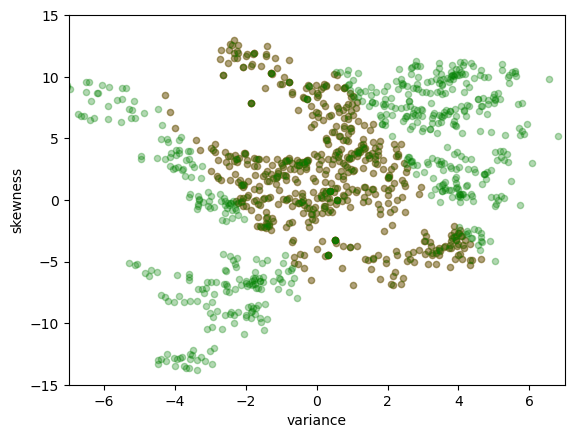

In [63]:
import pyomo.kernel as pmo

def svm_conic_dual(X, y, c=1):
    
    n, p = X.shape
    F = np.array([y.iloc[i]*np.append(1, X.iloc[i, :].to_numpy()) for i in range(n)])
    
    m = pmo.block()
    
    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=c/n) for i in range(n)])
    m.z = pmo.variable_list([pmo.variable() for i in range(n)])
    
    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.d = pmo.constraint_list([pmo.constraint(body=sum(F[i, j]*m.a[i] for i in range(n)) - m.z[j], rhs=0) for j in range(p + 1)]) 
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)
    
    # solve
    pmo.SolverFactory('mosek_direct').solve(m)
    
    # get the support
    S = [i for i in range(n) if (m.a[i]() > 0)]
    
    # create and return linear SVM
    w_bar = sum(m.a[i]() * F[i, :] for i in S)
    w = pd.Series({k: w_bar[j+1] for j, k in enumerate(X.columns)})
    b = w_bar[0]
    
    import warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        fig, ax = plt.subplots()
        X.iloc[S, :].plot(**kwargs, ax=ax, c='r', alpha=0.3)
        X.plot(**kwargs, ax=ax, c='g', alpha=0.3)

    return LinearSvm(w, b)

svm_v3 = svm_conic_dual(X_train, y_train, 200)
print(svm_v3.w, svm_v3.b)


In [64]:
validate(y_test, svm_v3.predict(X_test))

Matthews correlation coefficient (MCC) = 0.723
Precision =  85.8%
Recall =  88.2%
Accuracy =  86.2%


,Predicted Positive,Predicted Negative
Actual Positive,127,17
Actual Negative,21,110


0.7229432921543978

## A kernelized SVM

[Wikipedia](https://en.wikipedia.org/wiki/Kernel_method)

A kernalized version of the support vector machine is given by

$$y^{pred} = \text{sgn}\left(\sum_{i=1}^n \alpha_i y_i K(x_i, x)\right)$$

where $(x_i, y_i)$ are members of the training set, and $K(x_i, x)$ is a **kernel function**. Comparing to the dual formulation of a linear SVM, we see that $K(x_i, x) = x_i^\top x$ which shows an inner product is the kernel function for linear SVM. 

Kernel methods extend the framework provided introduced with linear support vector machines to a wider 

Recall the dual formulation in standard quadratic program with $n$ variables $\alpha_i$ for $i = 1, \dots, n$.

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( \bar{x}_i^\top \bar{x}_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where the $n \times n$ **Gram matrix** is defined as

$$
G = \begin{bmatrix} 
    y_1 y_1\bar{x}_1^\top \bar{x}_1 & \dots & y_1 y_n\bar{x}_1^\top \bar{x}_n \\ 
    \vdots & \ddots & \vdots \\ 
    y_n y_1 \bar{x}_n^\top \bar{x}_1 & \dots & y_n y_n\bar{x}_n^\top \bar{x}_n 
\end{bmatrix}
$$

The "Kernel Trick" entails replacing the inner products $\bar{x}_i^\top \bar{x}_j$ with the value of a kernel function $K(\bar{x}_i, \bar{x}_j)$ which results in the optimization problem

$$
\begin{align*}
\min_{\alpha_i}\ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(\bar{x}_i, \bar{x}_j)  -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where the Gram matrix becomes

$$
G = \begin{bmatrix} 
    y_1 y_1 K(\bar{x}_1, \bar{x}_1) & \dots & y_1 y_n K(\bar{x}_1, \bar{x}_n) \\ 
    \vdots & \ddots & \vdots \\ 
    y_n y_1 K(\bar{x}_n, \bar{x}_1) & \dots & y_n y_n K(\bar{x}_n, \bar{x}_n )
\end{bmatrix}
$$

Like an inner product, the kernel functions are measures of similarity between two vector quantities. The twist is that the similarity is measured in a "lifted" or "feature" space. That is, there is a function $\phi$ that maps $\bar{x}$ 

$$\phi: \mathbb{R}^{p+1} \rightarrow \cal{H}$$

The kernel function

$$K(\bar{x}, \bar{z}) = \langle \phi(\bar{x}), \phi(\bar{z})\rangle_\cal{H}$$

The resulting predictor is 

$$
\begin{align*}
    y^{pred} & = \text{sgn}(\bar{w}^\top \bar{x})
\end{align*}
$$

where

$$\bar{w} = \sum_{i=1}^n \alpha_i y_i \bar{x}_i$$

$$
\begin{align*}
    y^{pred} & = \text{sgn}\left(\sum_{i=1}^n \alpha_i y_i \bar{x}_i^\top \bar{x}\right)
\end{align*}
$$

$$
\begin{align*}
    y^{pred} & = \text{sgn}\left(\sum_{i=1}^n \alpha_i y_i K(\bar{x}_i, \bar{x})\right)
\end{align*}
$$

[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37, 39, 40, 42, 45, 46, 49, 50, 51, 53, 54, 56, 60, 62, 63, 65, 66, 67, 70, 71, 73, 74, 76, 77, 79, 80, 81, 83, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 102, 104, 105, 106, 107, 109, 111, 114, 115, 116, 117, 118, 119, 121, 122, 125, 126, 127, 128, 129, 130, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 145, 146, 148, 149, 151, 152, 153, 155, 158, 159, 160, 161, 166, 167, 168, 172, 173, 176, 177, 178, 180, 181, 182, 183, 185, 186, 187, 191, 192, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 224, 225, 226, 227, 228, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 262, 265, 268, 269, 270, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 285, 286, 288, 292, 293, 294, 298, 299, 303, 304, 305, 3

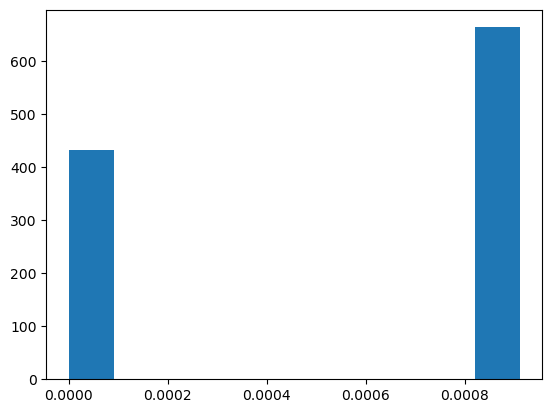

In [442]:
import numpy as np

import pyomo.kernel as pmo

kernel = lambda x, z : (1 + x @ z)**2

def svm_conic_dual(X, y, c, tol=1e-8):
    
    n, p = X.shape
    
    # convert to numpy arrays for speed
    X_ = np.hstack([np.ones((n, 1)), X.to_numpy()])
    y_ = y.to_numpy()
    
    # kernel matrix
    G = [[y_[i] * y_[j] * kernel(X_[i, :], X_[j, :]) for j in range(n)] for i in range(n)]
    
    # spectral factors for a positive semi-definite matrix
    eigvals, V = np.linalg.eigh(G)
    idx = (eigvals >= tol * max(eigvals))
    V = V[:, idx]
    eigvals = eigvals[idx]
    
    F = V @ np.diag(np.sqrt(eigvals))

    m = pmo.block()
    
    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=c/n) for i in range(n)])
    m.z = pmo.variable_list([pmo.variable() for i in range(n)])
    
    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.d = pmo.constraint_list([pmo.constraint(body=sum(F[i, j]*m.a[i] for i in range(n)) - m.z[j], rhs=0) for j in range(p + 1)]) 
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)
    
    # solve
    pmo.SolverFactory('mosek_direct').solve(m)
    
    # get svm parameters
    support = [i for i in range(n) if (m.a[i]() > 0)]
    print(support)
    w_aug = sum(m.a[i]() * F[i, :] for i in support)
    print(w_aug)
    
    plt.hist([m.a[i]() for i in range(n)])
    b = w_aug[0]
    w = pd.Series({k: w_aug[j+1] for j, k in enumerate(X.columns)})

    return LinearSvm(w, b)

c = 1.0
svm = svm_conic_dual(X_train, y_train, c)
print(svm.w, svm.b)

## Full Dataset

In [339]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)
print(df.columns)

# select training features
features = ["variance", "skewness"] #, "curtosis", "entropy"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

c = 1.0
svm = svm_conic_dual(X_train, y_train, c)
print(svm.w, svm.b)

validate(y_test, svm.predict(X_test))

Index(['variance', 'skewness', 'curtosis', 'entropy', 'class'], dtype='object')
variance    0.363410
skewness    0.116214
dtype: float64 -0.04839297368364593
Recall =  0.928
Precision =  0.855
Matthews correlation coefficient (MCC) =  0.743



,Predicted Positive,Predicted Negative
Actual Positive,141,11
Actual Negative,24,99


0.7434459025462694

## Pyomo Implementation

In [6]:
import numpy as np
import pyomo.environ as pyo


def svm_fit(X, y, lambd=0):

    m = pyo.ConcreteModel()

    # zero-based indexing
    n, p = X.shape
    m.n = pyo.RangeSet(0, n - 1)
    m.p = pyo.RangeSet(0, p - 1)

    m.w = pyo.Var(m.p)
    m.b = pyo.Var()
    m.z = pyo.Var(m.n, domain=pyo.NonNegativeReals)
    m.wpos = pyo.Var(m.p, domain=pyo.NonNegativeReals)
    m.wneg = pyo.Var(m.p, domain=pyo.NonNegativeReals)

    @m.Constraint(m.n)
    def hinge_loss(m, n):
        return m.z[n] >= 1 - y[n] * (sum(m.w[p] * X.iloc[n, p] for p in m.p) + m.b)

    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return sum(m.z[n] for n in m.n) / n + lambd * sum(
            m.wpos[p] + m.wneg[p] for p in m.p
        )

    pyo.SolverFactory("glpk").solve(m)

    w = np.array([m.w[p]() for p in m.p])
    b = m.b()

    # return a binary classifier
    def svm(x):
        return np.sign(w @ x + b)

    svm.w = w
    svm.b = b

    return svm


# create a linear SVM binary classifier

%timeit svm = svm_fit(X_train, y_train)

395 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


                   Test Data (n = 275)
                  y = 1       y = -1
 Predict y =  1      96        21    precision = 0.821
 Predict y = -1      13       145 
      Recall =     0.881


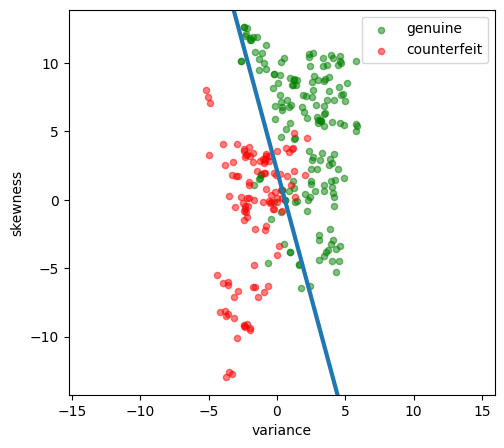

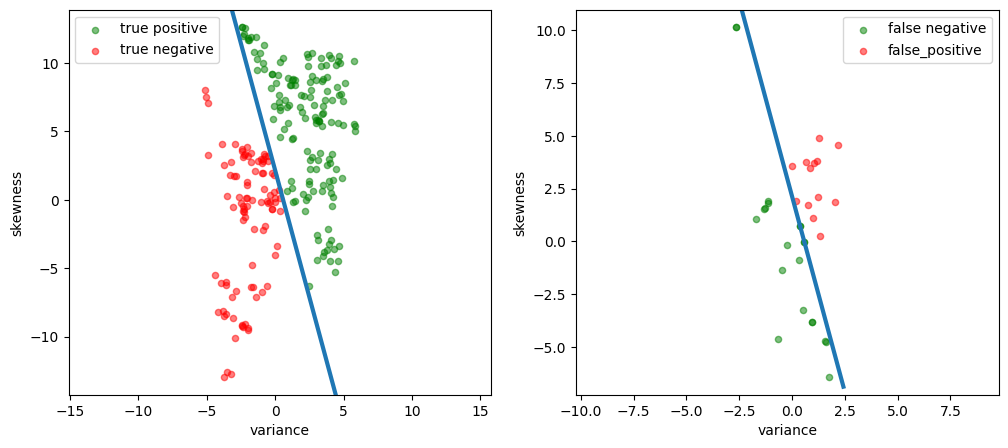

In [7]:
def svm_test(svm, X, y, plot=False):

    y_pred = pd.Series([svm(X.loc[i, :]) for i in X.index])

    true_pos = (y > 0) & (y_pred > 0)
    false_pos = (y < 0) & (y_pred > 0)
    false_neg = (y > 0) & (y_pred < 0)
    true_neg = (y < 0) & (y_pred < 0)

    tp = sum(true_pos)
    fp = sum(false_pos)
    fn = sum(false_neg)
    tn = sum(true_neg)

    print(f"                   Test Data (n = {len(y)})")
    print(f"                  y = 1       y = -1")
    print(f" Predict y =  1    {tp:4d}      {fp:4d}    precision = {tp/(tp + fp):5.3f}")
    print(f" Predict y = -1    {fn:4d}      {tn:4d} ")
    print(f"      Recall =     {tp/(tp + fn):5.3f}")

    if not plot:
        return

    def svm_line(svm, ax):
        w = svm.w
        b = svm.b
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.plot(
            [xmin, xmax], [-(w[0] * xmin + b) / w[1], -(w[0] * xmax + b) / w[1]], lw=3
        )
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 5))
    plot_Xy(X, y, ax)
    svm_line(svm, ax)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_Xy(X[true_pos], y[true_pos], ax[0])
    plot_Xy(X[true_neg], y[true_neg], ax[0])
    svm_line(svm, ax[0])
    ax[0].legend(["true positive", "true negative"])

    plot_Xy(X[false_pos], y[false_pos], ax[1])
    plot_Xy(X[false_neg], y[false_neg], ax[1])
    svm_line(svm, ax[1])
    ax[1].legend(["false negative", "false_positive"])


svm = svm_fit(X_train, y_train)
svm_test(svm, X_test, y_test, plot=True)

In [8]:
features = df.columns

# separate into features and outputs
X_train_full = df_train[features]
y_train_full = 2 * df_train["class"] - 1

# separate into features and outputs
X_test_full = df_test[features]
y_test_full = 2 * df_test["class"] - 1

# fit svm and test
svm = svm_fit(X_train_full, y_train_full)
svm_test(svm, X_test_full, y_test_full)

                   Test Data (n = 275)
                  y = 1       y = -1
 Predict y =  1     109         0    precision = 1.000
 Predict y = -1       0       166 
      Recall =     1.000


## The SVM Dual

Creating the dual of the support vector machine will turn out to have practical consequences. Creating the dual requires a differentiable objective function. For this reason, the regularization term is changed to the 2-norm of $w$

$$
\begin{align*}
\min_{z, w, b}\  \frac{1}{2} \|w\|_2^2 + \frac{c}{n}  \sum_{i=1}^n z_i \\
\\
\text{s.t.}\qquad 1 - y_i(w^\top x_i + b) - z_i & \leq 0 & \forall i = 1, \dots, n \\
- z_i & \leq 0 & \forall i = 1, \dots, n
\end{align*}
$$

where the regularization parameter shifted to $c$, and the constraints restated in standard form. This is a quadratic problem in $n + p + 1$ variables and $2n$ constraints.

The Lagrangian $\mathcal{L}$ is 

$$
\begin{align*}
\mathcal{L} & = \frac{1}{2} \|w\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i + \sum_{i=1}^n \alpha_i (1 - y_i(w^\top x_i + b) - z_i) + \sum_{i=1}^n \beta_i (-z_i) \\
\end{align*}
$$

where $2n$ non-negative Lagrange multipliers $\alpha_i \geq 0$ and $\beta_1 \geq 0$ have been introduced for $i \in 1,\dots,n$. Intuitively, the Lagrange variables are penalty weights assigned to the inequality constraints introduced into a modified objective function. If the penalties are large enough then the constraints will be satisfied.


$$
\begin{align*}
\frac{\partial \mathcal{L}}{\partial z_i} & = \frac{c}{n} - \alpha_i - \beta_i = 0 \implies 0 \leq \alpha_i \leq \frac{c}{n}\\
\frac{\partial \mathcal{L}}{\partial w} & = w  - \sum_{i=1}^n \alpha_i y_i x_i = 0 \implies  w = \sum_{i=1}^n \alpha_i y_i x_i \\
\frac{\partial \mathcal{L}}{\partial b} & = -\sum_{i=1}^n \alpha_i y_i = 0 \implies \sum_{i=1}^n \alpha_i y_i = 0 \\
\end{align*}
$$

The dual problem is then

$$
\begin{align*}
\max_{\alpha_i}\ &  \sum_{i=1}^n \alpha_i - \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( x_i^\top x_j ) \\
\text{s. t.}\quad & \sum_{i=1}^n \alpha_i y_i = 0 \\
& \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

Like the primal, the dual is a quadratic program. The dual, however, has only $n$ decision variables compared to $n + p + 1$ decision variables for the primal, and $n + 1$ constraints compared to $2n$ constraints for the primal. This reduction is significant for problems with many features (i.e, large $p$), or for large training sets (i.e., large $n$). The case of large $p$ becomes important when extending SVM to nonlinear classification using kernels. 

Note, however, that the reduced number of decision variables and constraints in the dual problem requires computing $\frac{n(n+1)}{2}$ inner products $(x_i^\top x_j)$ for $i \leq j$ and $i,j\in \mathbb{R}^n$.   The inner products can be arranged as a symmetric matrix 
$$
\begin{align*}
K = [k_{i,j}] = X X^\top = \begin{bmatrix}
x_1^\top x_1 & x_1^\top x_2 & \dots & x_1^\top x_n \\
x_2^\top x_1 & x_2^\top x_2 & \dots & x_2^\top x_n \\
\vdots & \vdots & \ddots & \vdots \\
x_n^\top x_1 & x_n^\top x_2 & \dots &  x_n^\top x_n \\
\end{bmatrix}
\end{align*}
$$

where $X \in \mathbb{R}^{n\times p}$ is the matrix formed by the $n$ feature vectors $x_i$ for $i=1, 2, \dots, n$. The symmetry of $K$, which is known as the Gram matrix (or Grammian) is a consequence of the symmetry of the inner product for real number spaces.

$$
\begin{align*}
w^* & = \sum_{i=1}^n \alpha_i^* y_i x_i \\
b^* & = y_k - (w^*)^\top x_k & \text{for any }k\ni 0 < \alpha_k < \frac{c}{n} \\
\end{align*}
$$

which can be written entirely in terms of the inner product.

$$
\begin{align*}
w^* & = \sum_{i=1}^n \alpha_i^* y_i x_i \\
b^* & = y_k - \sum_{i=1}^n \alpha_i^* y_i x_i^\top x_k & \text{for any }k\ni 0 < \alpha_k < \frac{c}{n} 
\end{align*}
$$

Given a value for the feature vector $x\in\mathbb{R}^p$, the classifier $\hat{y} = \text{sgn}\ \left((w^*)^\top x + b^* \right)$ is then 

$$
\begin{align*}
\hat{y} & = \text{sgn}\ \left( y_k + \sum_{i=1}^n \alpha_i^* y_i x^\top_i (x - x_k) \right)\\
\end{align*}
$$

This is result has important consequences. The key point is that is that the dual optimization problem can be solved with knowledge of the inner products appearing in the Gram matrix $K$, and the resulting classifier needs only inner products of training set data with the difference $x - x_k$ for some $k$ found in the optimization calculation.

In [9]:
import numpy as np
import pyomo.environ as pyo


def svm_dual_fit(X, y, lambd=0):

    m = pyo.ConcreteModel()

    X_np = X.to_numpy()

    K = X_np @ X_np.T

    # zero-based indexing
    n, p = X.shape
    m.n = pyo.RangeSet(0, n - 1)
    m.p = pyo.RangeSet(0, p - 1)

    m.a = pyo.Var(m.n, bounds=(0, 1))

    @m.Constraint()
    def sumya(m):
        return sum(y.loc[i] * m.a[i] for i in m.n) == 0

    @m.Objective(sense=pyo.maximize)
    def objective(m):
        return sum(m.a[i] for i in m.n) - 0.5 * sum(
            m.a[i] * m.a[j] * y.loc[i] * y.loc[j] * K[i, j] for i in m.n for j in m.n
        )

    pyo.SolverFactory("mosek_direct").solve(m)

    def svm():
        pass

    return svm


# create a linear SVM binary classifier
m = svm_dual_fit(X_test, y_test)

In [10]:
m = svm_dual_fit(X_test, y_test)
pyo.SolverFactory("mosek_direct").solve(m)

ValueError: The problem instance supplied to the <class 'pyomo.solvers.plugins.solvers.mosek_direct.MOSEKDirect'> plugin '_presolve' method must be a Model or a Block

## Bibliographic Notes

The development of support vector machines is largely attributed to Vladimir Vapnik and colleagues at AT&T Bell Laboratories during the 1990's. The seminal papers are highly readable and entry points to the literature.

> Boser, B. E., Guyon, I. M., & Vapnik, V. N. (1992, July). A training algorithm for optimal margin classifiers. In Proceedings of the fifth annual workshop on Computational learning theory (pp. 144-152).  https://dl.acm.org/doi/10.1145/130385.130401

> Cortes, C., & Vapnik, V. (1995). Support-vector networks. Machine learning, 20(3), 273-297. https://link.springer.com/content/pdf/10.1007/bf00994018.pdf

Support vector machines are a widely used method for supervised machine learning and described in tutorial blog postings and trade journal articles. Representative examples include 

> Sachin, D. N. (2020). Support Vector Machines with Amazon Food Reviews https://medium.com/analytics-vidhya/support-vector-machines-with-amazon-food-reviews-9fe0428e09ef

> http://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-linear-svm/



In [395]:
import pyomo.environ as pyo

class LinearSvmModel(pyo.ConcreteModel):
    
    def __init__(self, X_train, y_train):
        
        super().__init__()
        
        self.X = X_train
        self.y = y_train
        self.lambd = pyo.Param(mutable=True, initialize=0.0)
        
        # use dataframe columns and index to index vars and constraints
        self.P = pyo.Set(initialize=self.X.columns)
        self.N = pyo.Set(initialize=self.X.index)
        
        # decision variables
        self.wp = pyo.Var(self.P, domain=pyo.NonNegativeReals)
        self.wn = pyo.Var(self.P, domain=pyo.NonNegativeReals)
        self.b = pyo.Var()
        self.z = pyo.Var(self.N, domain=pyo.NonNegativeReals)
        
        @self.Expression(self.P)
        def w(self, p):
            return self.wp[p] - self.wn[p]
        
        @self.Objective(sense=pyo.minimize)
        def lasso(self):
            return sum(self.z[i] for i in self.N)/len(self.N) + self.lambd * sum(self.wp[p] + self.wn[p] for p in self.P)
        
        @self.Constraint(self.N)
        def hingeloss(self, i):
            return self.z[i] >= 1 - self.y[i] * (sum(self.w[p] * self.X.loc[i, p] for p in self.P) + self.b)
            
    def svm(self, lambd=0.0, solver="cbc"):
        self.lambd = lambd
        pyo.SolverFactory(solver).solve(self)
        w = pd.Series([self.w[p]() for p in self.P], index=self.P)
        b = self.b()
        return LinearSvm(w, b)
    